# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible).

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───assignment-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/assignment-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/assignment-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [0]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [0]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir assignment-pubfig831
!mv pubfig83lfw_raw_in_dirs assignment-pubfig831/correct
!rm -r assignment-pubfig831/correct/distract
!cp -r assignment-pubfig831/correct assignment-pubfig831/degraded

for image_path in tqdm(glob('assignment-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 12.7 GB | Proc size 153.6 MB
GPU RAM: Free 11441MB | Used 0MB | Util 0% | Total 11441MB


# References & Next Steps

Papers:
1. http://stanford.edu/class/ee367/Winter2017/yan_wang_ee367_win17_report.pdf
2. https://arxiv.org/pdf/1711.07064.pdf
3. https://arxiv.org/pdf/1609.04802.pdf

Implementation:
1. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?fbclid=IwAR28sijJUp4PISBoih5kuUXMmeOz6j8hMROF-tjhK6AaR_p32mNKRprwd2E
2. https://github.com/RaphaelMeudec/deblur-gan
3. https://github.com/KupynOrest/DeblurGAN
4. https://github.com/eriklindernoren/PyTorch-GAN

Observations:
1. L1 content loss + BCE adversarial loss not giving good results -- Faded images + Dull color 
2. Changing Upsample to Conv2dTranspose improved quality
3. L2 content loss giving better quality result than L1 content loss but smudged output
4. Replacing L1/L2 pixelwise loss with Perceptual loss helped in improving
output
5. Discriminator not working well in L2 perceptual loss. L1 perceptual loss tend to converge faster. Would need to run more test here.

Metrics to check:
1. PSNR

Potential Next Steps:
1. Using WGAN-GP or MSE for adversarial loss.
2. To check why colour quality is not good in the generator output.
3. Visualizing activation of VGG19 with input image to decide layer for content loss 
4. Changing generator architecture -- Testing something like Unet

# **Main Code**

## Data Loading

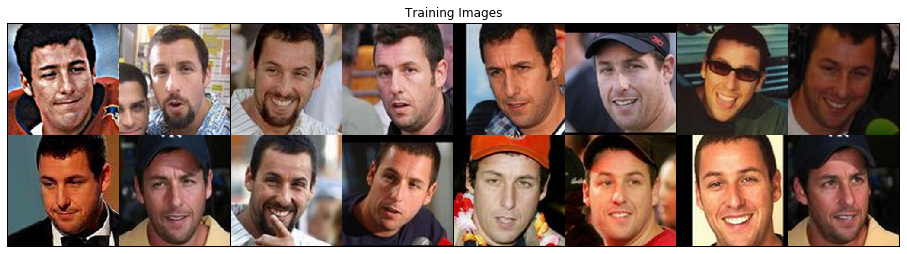

In [0]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.parallel
import torchvision.utils as vutils
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
from torchvision.models import vgg19

# Specify Batch Size
batch_size = 16

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

dataset_correct = dset.ImageFolder(root='assignment-pubfig831/correct/train/',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                                                       
                           ]))

dataloader_correct = torch.utils.data.DataLoader(dataset_correct, batch_size=batch_size, shuffle=False)

correct_batch = next(iter(dataloader_correct))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(correct_batch[0], padding=2, normalize=True).cpu(),(1,2,0)))


dataset_degraded = dset.ImageFolder(root='assignment-pubfig831/degraded/train/',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                                                       
                           ]))

dataloader_degraded = torch.utils.data.DataLoader(dataset_degraded, batch_size=batch_size, shuffle=False)

In [0]:
# Lazy DataLoader Assumption -- Order of images same in correct and degraded folder -- directly using independent loader without shuffle for pairing

train_correct_filename = [os.listdir('assignment-pubfig831/correct/train/'+celeb) for celeb in os.listdir('assignment-pubfig831/correct/train/')] 
train_degraded_filename = [os.listdir('assignment-pubfig831/degraded/train/'+celeb) for celeb in os.listdir('assignment-pubfig831/degraded/train/')]

if train_correct_filename == train_degraded_filename:
  print('Correct and degraded image order same')

Correct and degraded image order same


## Structure

### **Constants and Hyperparemeters**

In [0]:
# Number of Image Channel
nc = 3
# Beta1 hyperparam for Adam Optimizer
beta1 = 0.5
# Learning Rate
lr = 0.0002
# Batch size
batch_size = 16
# Number of epochs
num_epoch = 3
# Feature maps in generator
ngf = 64
# Feature maps in discriminator
ndf = 64

### Generator Model

In [0]:
# custom weights initialization called on netG and netD [Reference: DCGAN Pytorch]
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Generator CycleGAN [Reference: Cycle GAN Pytorch]
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks):
        super(GeneratorResNet, self).__init__()
        channels = nc

        # Initial convolution block
        out_features = ngf
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1), 
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels),nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


netG = GeneratorResNet(5).to(device)
print(netG)

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256

### Discriminator Model

In [0]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator().to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

### Loss Functions

In [0]:
# Loss
criterion = nn.BCELoss()
criterion_pixelwise_l2 = nn.MSELoss()
criterion_pixelwise_l1 = nn.L1Loss()

# For Perceptual Loss [Reference: https://github.com/eriklindernoren/PyTorch-GAN]
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

feature_extractor = FeatureExtractor()
feature_extractor.eval()
feature_extractor.to(device)

FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

### Optimizer

In [0]:
# Optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Preprocessing

### Setting device to use for tensor operations

In [0]:
# Done 

### Initializing weights (if required)

In [0]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

## Training

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # model_save_name = '20193110_dcgan_perceptual_l1.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# # torch.save(netG.state_dict(), path)

# model_save_name = '20193110_dcgan_perceptual_l1.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# netG.load_state_dict(torch.load(path))

Mounted at /content/gdrive


<All keys matched successfully>

In [0]:
# BCE for Adversarial loss and VGG19 L1 loss for Perceptual Loss
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

print("Starting Training Loop...")
d_loss_list = []
g_loss_list = []

iter_num = 0
for epoch in range(num_epoch):

  iter_degraded = iter(dataloader_degraded)
  iter_correct = iter(dataloader_correct)

  for i in range(len(dataloader_correct)):
    
    # Read Batch
    degraded_X, _ = next(iter_degraded)
    degraded_X = degraded_X.to(device)
    correct_X, _ = next(iter_correct)
    correct_X = correct_X.to(device)

    ####################################
    ####### DISCRIMINATOR ##############
    ####################################

    G_corrected_output = netG(degraded_X)
    D_correct_output = netD(correct_X)

    # All Real Batch
    netD.zero_grad()
    label = torch.full((correct_X.size(0),), real_label, device=device)
    errD_real = criterion(D_correct_output.view(-1), label)
    errD_real.backward(retain_graph=True)
    D_x = D_correct_output.mean().item()
    
    # All Fake Batch
    label = torch.full((degraded_X.size(0),), fake_label, device=device)
    D_corrected_output = netD(G_corrected_output.detach())
    errD_fake = criterion(D_corrected_output.view(-1), label)
    errD_fake.backward(retain_graph=True)
    D_G_z1 = D_corrected_output.mean().item()
    errD = errD_fake + errD_real
    # Update D
    optimizerD.step()

    ####################################
    ####### GENERATOR ##############
    ####################################

    netG.zero_grad()
    label.fill_(real_label)
    D_corrected_output = netD(G_corrected_output)
    errG_adversial = criterion(D_corrected_output.view(-1), label)
    
    # Pixelwise L2 Loss
    #errG_content = criterion_pixelwise_l2(G_corrected_output, correct_X)
    # Perceptual Loss
    real_features = feature_extractor(correct_X)
    gen_features = feature_extractor(G_corrected_output)
    errG_content = criterion_pixelwise_l1(gen_features, real_features.detach())

    # correct_features = feature_extractor(correct_X)
    # corrected_features = feature_extractor(G_corrected_output)
    # errG_content = criterion_pixelwise_l1(corrected_features, correct_features.detach())

    D_G_z2 = D_corrected_output.mean().item()
    errG = errG_content + 0.001*errG_adversial 
    errG.backward()
    optimizerG.step()

    if iter_num%10 == 1:
      print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % ( i, len(dataloader_correct),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
    iter_num += 1  
    d_loss_list.append(errD.item())
    g_loss_list.append(errG.item())

Starting Training Loop...
[1/545]	Loss_D: 3.3636	Loss_G: 0.8931	D(x): 0.3062	D(G(z)): 0.0000 / 0.0000
[11/545]	Loss_D: 0.0158	Loss_G: 0.6946	D(x): 0.9864	D(G(z)): 0.0005 / 0.0001
[21/545]	Loss_D: 0.0055	Loss_G: 0.6472	D(x): 0.9992	D(G(z)): 0.0045 / 0.0000
[31/545]	Loss_D: 0.0002	Loss_G: 0.6391	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[41/545]	Loss_D: 0.0085	Loss_G: 0.5674	D(x): 0.9920	D(G(z)): 0.0000 / 0.0000
[51/545]	Loss_D: 0.0000	Loss_G: 0.6034	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[61/545]	Loss_D: 0.0000	Loss_G: 0.5683	D(x): 1.0000	D(G(z)): 0.0000 / 0.0001
[71/545]	Loss_D: 0.0000	Loss_G: 0.6050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[81/545]	Loss_D: 0.0000	Loss_G: 0.5392	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/545]	Loss_D: 0.0000	Loss_G: 0.5185	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[101/545]	Loss_D: 0.0002	Loss_G: 0.4740	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[111/545]	Loss_D: 0.0000	Loss_G: 0.5491	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[121/545]	Loss_D: 0.0000	Loss_G: 0.5182	D(x): 1.0

KeyboardInterrupt: ignored

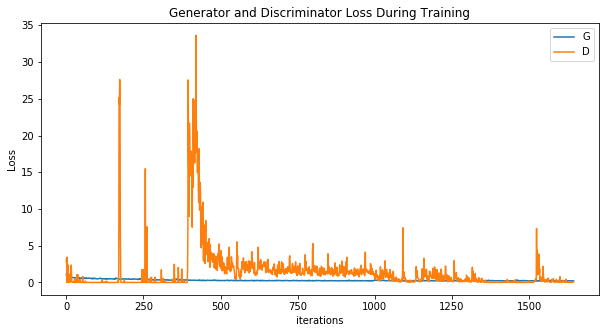

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_list,label="G")
plt.plot(d_loss_list,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

In [0]:
netG.eval()

def denormalize(image_tensor):
    # denormalize the normalized image tensor(N,C,H,W) with mean=0.5 and std=0.5 for each channel
    image_tensor = image_tensor + 1
    image_tensor = image_tensor - image_tensor.min()
    image_tensor = image_tensor / (image_tensor.max() - image_tensor.min())
    return image_tensor
    #(image_tensor + 1) / 2.0
    

def fix(image: np.ndarray) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array, and return its fixed version in the same format.
    """
    image = image[:,:,::-1]
    image = transforms.Compose([transforms.ToPILImage(),transforms.Resize(256), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])(image).unsqueeze(0).to(device)

    image = to_pil_image(denormalize(netG(image)).squeeze().cpu())
    image = np.array(transforms.Compose([transforms.Resize(250)])(image))
    
    return image[:,:,::-1]

# Results
Run this block after done to look at some of the results of the fix function yourself.

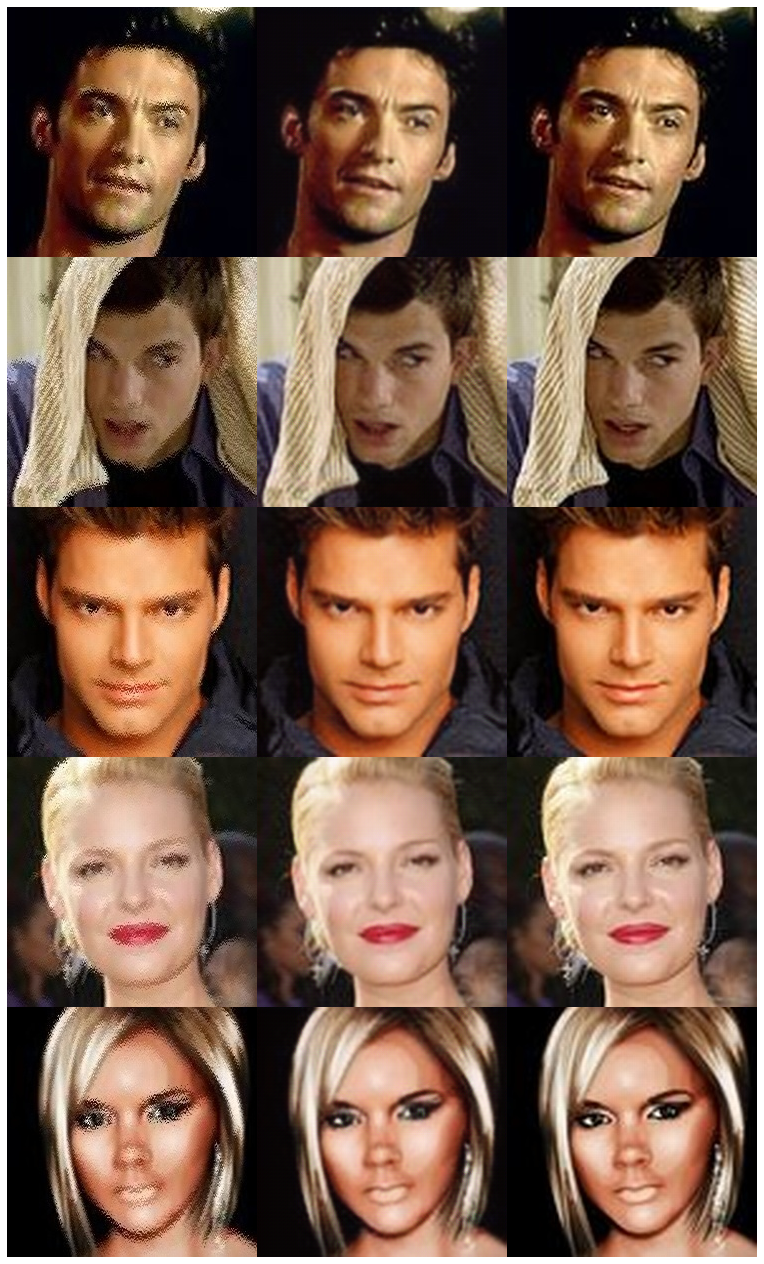

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/assignment-pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()